# Quantum Approximate Optimization Algorithm: Maximum-Cut Problem

## *Abstract*

*In this tutorial, we use Qiskit to simulate a hybrid quantum-classical variational algorithm called Quantum Approximate Optimization Algorithm (QAOA). We will use Maximum-Cut as an example to show how to implement QAOA circuit through the combination of a quantum algorithm and gradient-descend algorithm to find the local maximum.*  

## Introduction

Roughly speaking, the main idea of QAOA [[1](https://arxiv.org/abs/1411.4028v1)] is "marking" the optimized states by successive sets of $U(C,\alpha)$ operators and $U(B,\beta)$ operators. When we measure the output, the mean value varies with our choice of the parameters defined in the $R_{z}$ gates and $R_{x}$ gates. Using proper classical optimization, an approximate local optimum is obtained by changing the variational parameters. 

What makes QAOA stand out is that it only asks for a low-depth circuit to get an approximate optimized result. This is a huge advantage because lower depth means fewer error in the near-term quantum devices. However, the cost of its advantage is to find a good set of parameters efficiently by classical algorithms [[2](https://arxiv.org/abs/1812.01041v1)]. 

QAOA has been proposed and proved to be a powerful quantum algorithm to tackle combinatorial optimization problems. One of the toy example which has been well studied is MaxCut problem. Apart from the combinatorial optimization, many applications of QAOA have been brought about including lattice protein folding problem, traverse field Ising model and many other problems.

This tutorial apply QAOA to the MaxCut problem using Qiskit and includes two major parts: quantum circuit implementation and classical optimization.

## Introduction to the maximum cut problem

Here we investigate an unweighted, undirected graph consisting of five vertexes and six edges. The problem is defined to find the maximum number of cut between a vertex of a subset and the other vertex of the complementary subset. For instance, we can denote each vertex by a state, $z_{i}$, and then we assign values of 1 or 0 to them as two different subsets.  

<img src="graph11" width ="300">

$$|z_{i}\rangle = |1\rangle , |0\rangle$$


<img src="graph1.png" width ="300">

Any arbitrary combination is represented by state $|s\rangle$ :
$$|s\rangle = |z_{0}z_{1}z_{2} \cdots z_{n} \rangle$$
It is obvious that there are $2^{n}$ ways of combination for an n-vertex graph. For a graph of 5 vertexes, the maximum cuts can be found by trying through 32 possible states. 

<img src="maxcut4.png" width ="350"> 

The graph shown is the optimized state, $|s_{max}\rangle$, and the corresponding number of cuts is 5. 

$$| s_{max} \rangle = |01010\rangle, |10101\rangle$$  

Yet the time complexity grows exponentially with the vertexes involved ($O(2^{n})$). Luckily, we can make full use of quantum superposition and entanglement to find the optimum more efficiently.

## Quantum Approximate Optimization Algorithm



### Objective Function 

We start with the definition of the objective function. This function takes any state as input and output the number of cuts.

$$C(s) = \sum^{m}_{\langle ij \rangle}C_{\langle ij \rangle}(|z_{i}z_{j}\rangle)$$

The equivalent operator acts on any edge in the graph, and the eigenvalue is 1 or 0. This operator yields one if the edge is linked by the two different subsets of vertexes, and 0 otherwise.

$$C = \sum_{\langle ij \rangle}C_{\langle ij \rangle}$$
 
$$ C_{\langle ij \rangle} |z_{i}z_{j} \rangle = 1 \ |z_{i}z_{j} \rangle , \ z_{i} \neq  z_{j} $$
$$ C_{\langle ij \rangle} |z_{i}z_{j} \rangle = 0 \ |z_{i}z_{j} \rangle , \ z_{i} =  z_{j} $$ 
  
### Operator $U(C,\alpha)$

We now introduce the operator function $U(C,\alpha)$:
$$ U(C,\alpha) = e^{-i  \alpha  C} = e^{-i \ \alpha \ \sum_{\langle ij \rangle}C_{\langle ij \rangle}} = \prod^{m}_{\langle ij \rangle} e^{- i \alpha C_{\langle ij \rangle} } $$

Where $\langle ij \rangle$ is each edge jointed by vertexes $z_{i}$ and $z_{j}$. This unitary operator is diagonal in the computational basis, therefore it can be viewed as a spectral decomposition:
$$e^{- i \alpha C_{\langle ij \rangle}} = |00\rangle\ \langle00| + |11\rangle\ \langle 11| + e^{- i \alpha}|01\rangle\ \langle01| + e^{- i \alpha}|10\rangle\ \langle10|$$

This means if we apply operator $U(C,\alpha)$ to $|z_{i}z_{j}\rangle$, this state will be multiply by a phase $e^{-i\alpha}$ if $z_{i} \neq z_{j}$:
$$ e^{- i \alpha C_{\langle ij \rangle} } \vert 00 \rangle = \vert 00 \rangle $$
$$ e^{- i \alpha C_{\langle ij \rangle} } \vert 11 \rangle = \vert 11 \rangle $$
$$ e^{- i \alpha C_{\langle ij \rangle} } \vert 10 \rangle = e^{- i \alpha} \vert 10 \rangle $$
$$   e^{- i \alpha C_{\langle ij \rangle} } \vert 01 \rangle = e^{- i \alpha} \vert 01 \rangle $$
In this way we can "mark" the optimized state and later on we will "rotate" this state by operator $U(C,\beta)$.

### Operator $U(C,\beta)$
The operator $B$ is defined as:
$$B = \sum^{n}_{j=1}\sigma^{x}_{j}$$
It is natural to define the correspoding rotation operator:
$$U(B,\beta)=e^{-i\beta B}=e^{-i\beta\sum^{n}_{j=1}\sigma^{x}_{j}}= \prod^{n}_{j=1}e^{-i\beta \sigma^{x}_{j}}$$
In the view of Blcoh sphere, the rotation operator $e^{-i\beta\sigma^{x}}$ rotates the state about $x$ axis. Hence the probability of this state is changed and we will acquire an informative result if we measure it. 

### Algorithm 
The implementation of QAOA for Maxcut problem [[3](https://www.cs.umd.edu/class/fall2018/cmsc657/projects/group_16.pdf)] is shown as follow (n=5):

1. Initialization 

 Register a n-qubits state, and create superposition by n Hadmard gates.
$$|\psi_{0} \rangle = |00000 \rangle $$

$$ |\psi_{0} \rangle \stackrel{H^{\otimes n}}{\longrightarrow}|\psi_{i}\rangle =  (\frac{|0\rangle + |1\rangle}{\sqrt{2}})^{\otimes n} =\sum_{s\in\{0,1\}^n} \frac{1}{\sqrt{2^{n}}} \vert s \rangle $$

2. Applying $U(C,\alpha)$ and $U(C,\beta)$

 By alternately applying unitary operators $U(C,\alpha)$ and $U(C,\beta)$ to the initialied state $|\psi_{i}\rangle$, a new state $|\vec{\alpha},\vec{\beta}\rangle$ is generated by two sets of parameters $\vec{\alpha}$ and $\vec{\beta}$. 
 $$|\vec{\alpha},\vec{\beta}\rangle = U(B,\beta_{p})U(C,\alpha)...U(B,\beta_{2})U(C,\alpha_{2})U(B,\beta_{1})U(C,\alpha_{1})|\psi_{i}\rangle $$
Where $\vec{\alpha} =(\alpha_{1},\alpha_{2},...,\alpha_{p})$ and $\vec{\beta} = (\beta_{1},\beta_{2},...,\beta_{p})$ and $p$ is the depth of this algorithm.

3. Measurement and Expectation

 Measure the classical bit of $|\vec{\alpha},\vec{\beta}\rangle$, then calculate the mean value by objective operator $C$.
 $$|\vec{\alpha},\vec{\beta}\rangle \stackrel{C}{\longrightarrow}C|\vec{\alpha},\vec{\beta}\rangle \stackrel{}{\longrightarrow}M_{p}(\vec{\alpha},\vec{\beta})=\langle \vec{\alpha},\vec{\beta}| C |\vec{\alpha},\vec{\beta}\rangle $$
 
4. Classical Optimization
 
 Feed the parameters set and $M_{p}$ into classical optimizer and update a new set of $\vec{\alpha},\vec{\beta}$. Then go back to step 2 and 3 to output a new mean value $M_{p}$. Go through step 2 to 3 repetively until a local maximum is found.
 <img src="loop.png" width = "500"> 

## The Implementation of QAOA with Qiskit

We now code the quantum circuit of QAOA with Qiskit.

*NOTICE: The number of shots should be large enough, otherwise the classical optimization involving gradient calculation will fail*

### Import Packages and Tools

In [1]:
import itertools
import qiskit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import *
from qiskit import BasicAer, IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info.analysis import *
from qiskit.tools.visualization import circuit_drawer, plot_bloch_multivector

pi = np.pi

In [2]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 99999 ## This value should be large enough

### Preload Functions
All the functions we will use in this tutorial is preloaded here, but these functions will be explained in detail in the following sections. So we should skip this part and go on our tutorial.

In [3]:
def uz(circ, node, aux, graph, a):      # theta takes value in [0, 2pi]
    step_len = 1/100
    for[i,j] in graph:
         circ.cx(node[i],node[j])
         circ.rz(-2*step_len*pi*a,node[j])
         circ.cx(node[i],node[j])
         circ.rz(2*step_len*pi*a,aux)
         circ.barrier()

def ux(circ,node,b):       
    step_len = 1/100
    circ.rx(4*step_len*pi*b, node)
    circ.barrier()
    
def maxcut(circ, node, aux, creq,graph, ang_zip):
    for a,b in ang_zip:
        uz(circ, node, aux, graph, a)
        ux(circ, node, b)
    circ.measure(node, creq)

# Calculate the mean value from the measurement 
def mean(graph,answer):
    sum2 = 0
    for k,v in answer.items():
        sum1 = 0
        for [i,j] in graph:
            if k[i] != k[j]:
                sum1 += 1
        sum2 += sum1*v
    mean = sum2/shots
    return(mean)

def outcome(n,graph,ang1,ang2):
    ang_zip = zip(ang1,ang2)
    node = QuantumRegister(n)
    aux = QuantumRegister(1)
    creq = ClassicalRegister(n)
    circ = QuantumCircuit(node,aux,creq)
    circ.h(node)
    maxcut(circ, node, aux, creq,graph, ang_zip)
    results = execute(circ, backend = backend, shots = shots).result()
    answer = results.get_counts()
    out = mean(graph,answer)
    return(out)

def gradient(n,graph,ang1,ang2,step_len=1):
    ang1_dif = []
    ang2_dif = []
    res = outcome(n,graph,ang1,ang2)
    for i in range(len(ang1)):
        angp = ang1.copy()
        angp[i] += step_len
        resp = (outcome(n,graph,angp,ang2)-res)/step_len
        ang1_dif = np.append(ang1_dif,resp)
    
    for i in range(len(ang2)):
        angp = ang2.copy()
        angp[i] += step_len
        resp = (outcome(n,graph,ang1,angp)-res)/step_len
        ang2_dif = np.append(ang2_dif,resp)
    
    return(np.vstack((ang1_dif,ang2_dif)))

## gradient descend algorithm
def gra_desc(n,graph,ang1,ang2,step_size=1):
    iter_num = 100
    threshold = 0.01
    t = 0
    s = step_size
    x0 = np.vstack((ang1,ang2))
    gra0 = gradient(n,graph,x0[0],x0[1])
    x1 = x0 + s * gra0
    gra1 = gradient(n,graph,x1[0],x1[1])
    f1 = outcome(n,graph,x1[0],x1[1])
    times = 0
    for i in range(iter_num):
        del_x = np.hstack(x1 - x0)
        del_df = np.hstack(gra1 - gra0)
        s = abs(np.dot(del_x,del_df)/(np.dot(del_df,del_df))) 
        x2 = x1 + s * gra1
        f2 = outcome(n,graph,x2[0],x2[1])   
        gra2 = gradient(n,graph,x2[0],x2[1])
        times += 1
        print(x2,f2)
        if(abs(f2-f1) < threshold):            
            print('ok')
            return(x2,f2)
        while(f1 > f2 and t < 10):
            t = t + 1
            s = s * 0.9
            x2 = x1 + s * gra1
            f2 = outcome(n,graph,x2[0],x2[1])
        x0 = x1
        gra0 = gra1
        gra1 = gra2
        x1 = x2
        f1 = f2
    return(x1,f1)

def init_localmax():
    ang1 = [random.randint(0,100)]
    ang2 = [random.randint(0,100)]
    res = gra_desc(n,graph,ang1,ang2)
    opti_ang = res[0]
    return(opti_ang) 

def QAOA(n,graph,pmax):
    print('[a,b]  M(a,b)')
    p = 1
    print('p = %d' % p)
    opti_ang = init_localmax()
    while(p < pmax): 
        p = p + 1
        print('p = %d' % p)
        opti_ang1 = opti_ang[0]
        opti_ang2 = opti_ang[1]
        start_ang1 = np.zeros(p)
        start_ang2 = np.zeros(p)
        for i in range(p):
            if i == 0: 
                start_ang1[i] = opti_ang1[0]
                start_ang2[i] = opti_ang2[0]
            if i == p-1:
                start_ang1[i] = opti_ang1[p-2]
                start_ang2[i] = opti_ang2[p-2]
            else:
                start_ang1[i] = (i/(p-1))*opti_ang1[i-1] + ((p-i-1)/(p-1))*opti_ang1[i]
                start_ang2[i] = (i/(p-1))*opti_ang2[i-1] + ((p-i-1)/(p-1))*opti_ang2[i]

        res = gra_desc(n,graph,start_ang1,start_ang2)
        opti_ang = res[0]
        opti_val = res[1]
    print('done')

### Initialization

We still use the example graph mentioned previously. Each vertex is represented by a quantum state $|z_{i}\rangle$ and each edge is denoted by the two adjoint vertexes $|z_{i}z_{j}\rangle$.
<img src="graph.png" width = "300"> 

In [5]:
# Initialization
graph = [[0,1],[1,2],[1,4],[2,3],[3,4],[4,0]] # define the graph
n = 5 # the number of vertexes
node = QuantumRegister(n) # register qubits
aux = QuantumRegister(1)     # register an auxiliary qubit
creq = ClassicalRegister(n)

### Implementation of $U(C,\alpha)$

For a specific edge $\langle ij \rangle$, the two-bit unitary operator $U(C_{ij},\alpha)$ can be implemented in this form:
<img src="twobits.png" width = "400"> 

This is because any two-bit control unitary matrix is equivalent to the combination of two $CX$ gates and three unitary $2 \times 2$ gates $A, B, C$ algebraically [[4](https://arxiv.org/abs/quant-ph/9503016)]. We denote this two-bit network by operator $U(2)$ and apply to the computational basis of two qubits by definition.

$$ U(2)|00\rangle = I \otimes CBA |00\rangle $$
$$  U(2)|11\rangle = I \otimes C \cdot \sigma^{x} \cdot B \cdot \sigma^{x} \cdot A |11\rangle $$
$$  U(2)|10\rangle = I \otimes C \cdot \sigma^{x} \cdot B \cdot \sigma^{x} \cdot A |10\rangle $$
$$  U(2)|01\rangle = I \otimes CBA |01\rangle $$

These equations are then compared to the equalvalance by applying $U(C_{ij},\alpha) = e^{-i \alpha C_{\langle ij \rangle}} = U(2)$

$$ e^{- i \alpha C_{\langle ij \rangle} } \vert 00 \rangle = \vert 00 \rangle $$ 
$$ e^{- i \alpha C_{\langle ij \rangle} } \vert 11 \rangle = \vert 11 \rangle $$
$$ e^{- i \alpha C_{\langle ij \rangle} } \vert 10 \rangle = e^{- i \alpha} \vert 10 \rangle $$
$$ e^{- i \alpha C_{\langle ij \rangle} } \vert 01 \rangle = e^{- i \alpha} \vert 01 \rangle $$
   
We now deduce some resulting equaitons:


$$ CBA|0\rangle = |0\rangle $$
$$ C \cdot \sigma^{x} \cdot B \cdot \sigma^{x} \cdot A |1\rangle = |1\rangle $$
$$ C \cdot \sigma^{x} \cdot B \cdot \sigma^{x} \cdot A |0\rangle = e^{- i \alpha}|0\rangle $$
$$ CBA |1\rangle = e^{- i \alpha}|1\rangle $$

There exists a possible solution:


$$ A = I $$
$$ C = I $$
$$ B|0\rangle =  |0\rangle  $$
$$ B|1\rangle = e^{-i\alpha} |1\rangle $$


The role of $B$ can be done by two $Rz$ gates, along with an auxiliary qubit $|0\rangle$ [[3](https://www.cs.umd.edu/class/fall2018/cmsc657/projects/group_16.pdf)].
$$ Rz (-\alpha) \otimes Rz(\alpha) |0\rangle |0\rangle_{aux} = (e^{-i \frac{-\alpha}{2}} |0\rangle ) \otimes (e^{-i \frac{\alpha}{2}}|0\rangle_{aux})=|0\rangle |0\rangle_{aux} $$

$$ Rz (-\alpha) \otimes Rz(\alpha) |1\rangle |0\rangle_{aux} = (e^{-i \frac{\alpha}{2}} |1\rangle) \otimes (e^{-i \frac{\alpha}{2}}|0\rangle_{aux})=
e^{-i\alpha}|1\rangle |0\rangle_{aux}$$
The two-bit operator $U(2)$ therefore can be implemented as:
<img src="uc.png" width = "400">

In [6]:
## The definition of U(C,a)

def uz(circ, node, aux, graph, a):      # theta takes value in [0, 2pi]
    step_len = 1/100
    for[i,j] in graph:
         circ.cx(node[i],node[j])
         circ.rz(-2*step_len*pi*a,node[j])
         circ.cx(node[i],node[j])
         circ.rz(2*step_len*pi*a,aux)
         circ.barrier()

### Implementation of $U(B,\beta)$

It is straightforward to implement $U(B,\beta)$ by simply inserting $Rx$ operator into each qubit.

In [7]:
def ux(circ,node,b):       
    step_len = 1/100
    circ.rx(4*step_len*pi*b, node)
    circ.barrier()

### Implementation of QAOA Quantum Circuit

To create the QAOA circuit, we need to initialize the depth of this circuit, $p$ and the parameters set $\vec{\alpha}$ and $\vec{\beta}$. For the convenience of our analysis, we define $a,b$ lying in the interval $[0,100]$ to replace $\alpha,\beta$ lying in $[0,2\pi]$
$$  p=2 $$
$$ \vec{\alpha} = (32,45) $$
$$  \vec{\beta} = (41,23) $$


In [8]:

# This function is used to implement QAOA circuit  
def maxcut(circ, node, aux, creq,graph, ang_zip):
    for a,b in ang_zip:
        uz(circ, node, aux, graph, a)
        ux(circ, node, b)
    circ.measure(node, creq)

# Calculate the mean value from the measurement 
def mean(graph,answer):
    sum2 = 0
    for k,v in answer.items():
        sum1 = 0
        for [i,j] in graph:
            if k[i] != k[j]:
                sum1 += 1
        sum2 += sum1*v
    mean = sum2/shots
    return(mean)

The code of QAOA circuit is shown as below:

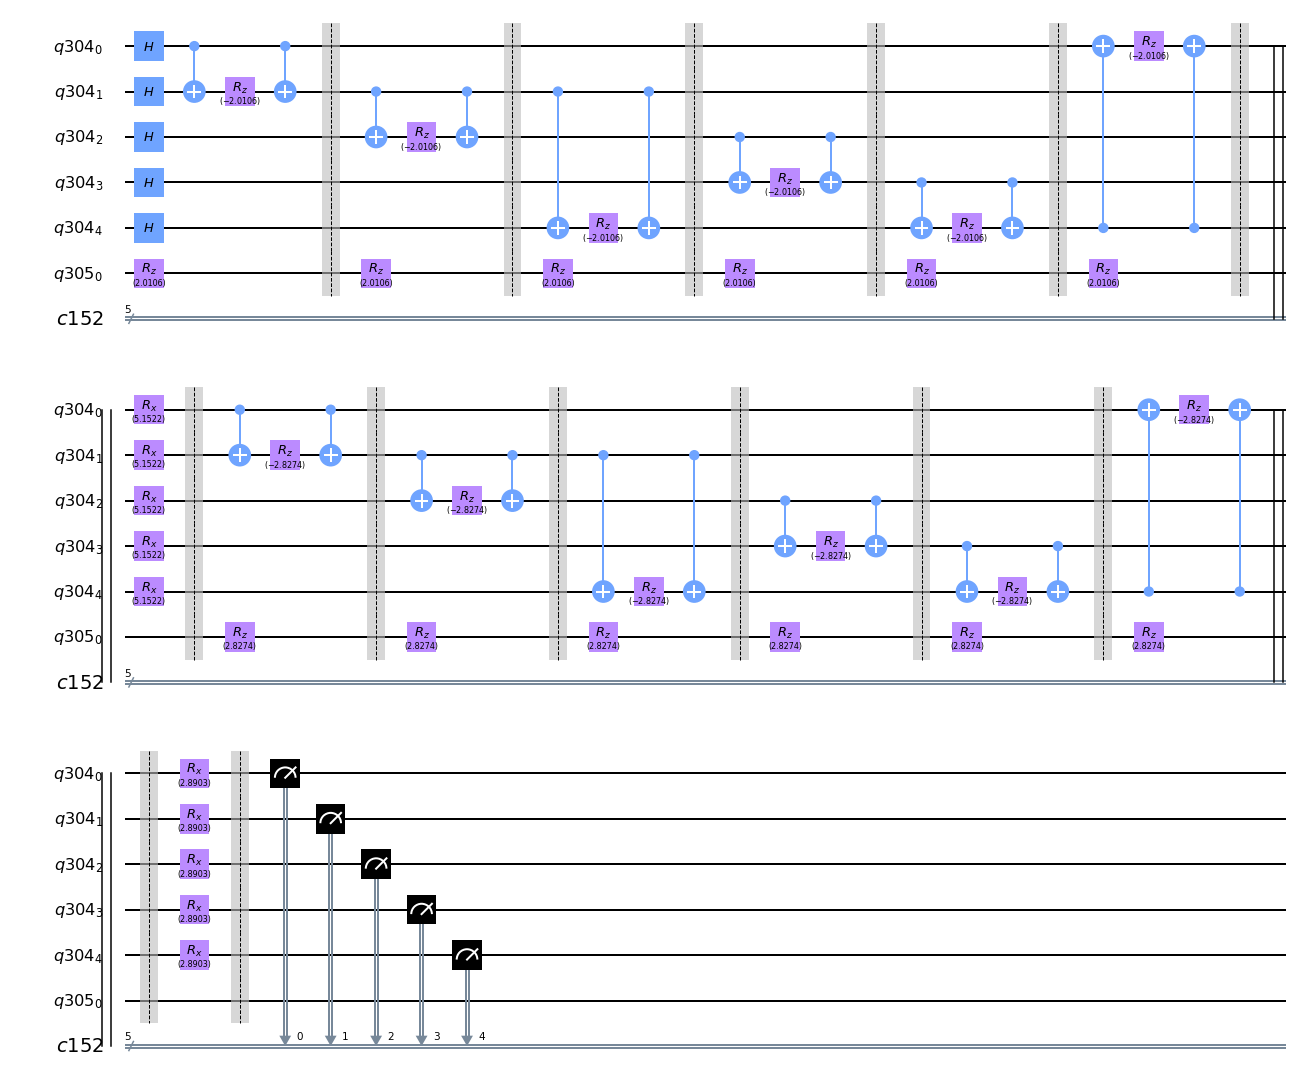

In [9]:
a = [32,45]
b = [41,23]
ang_zip = zip(a,b)
circ = QuantumCircuit(node,aux,creq)
circ.h(node)
maxcut(circ, node, aux, creq,graph, ang_zip)
circ.draw(output = 'mpl')

We then analyze the result of classical measurement:

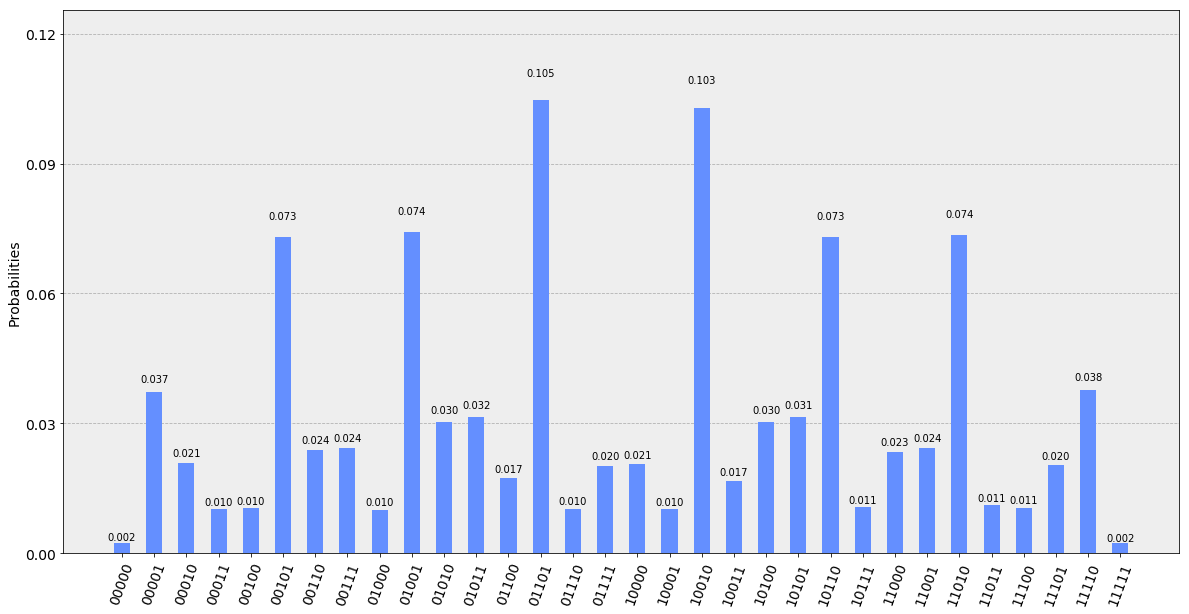

In [10]:
results = execute(circ, backend = backend, shots = shots).result()
answer = results.get_counts()
plot_histogram(answer, figsize=(20,10))

This histogram graph explains how QAOA works with the help of $U(C,\alpha)$ and $U(B,\beta)$. These operators change the probabilities of some states. In this case, the probabilities for states like $|00101\rangle$, $|01101\rangle$, $|10010\rangle$ are higher than any other state. The next step is to calculate the mean value based on the measurement.

In [11]:
# The mean value for a = [32,45], b = [41,23]
mean(graph,answer)

3.6673766737667375

But this is not a local optimized result, so a classical optimization is needed to get a better outcome. 

 ### Classical Optimization
In this part, we would like to introduce two frequently-used classical algorithms involved in QAOA, Gradient Descend algorithm (ascend, in the case of MaxCut) and Interpolation combined [[2](https://arxiv.org/abs/1812.01041v1)]. We send the result to the optimizer and gain updated parameters to run through the same steps of the quantum algorithm. This loop will be terminated when a local maximum is reached.

We need to modify our quantum algorithm with two classical algorithms. The workflow of our modified hybrid algorithm is:
 
<img src="workflow.png" width = "500"> 
   
The whole loop is ended when a designated depth of $p$ is reached.

#### Gradient Descend (Ascend) Algorithm

Gradient descend utilizes the gradient of the function at the current point to takes steps to the next point. If the function goes with the positive gradient and takes sufficiently small steps, then a local maximum can be guaranteed.
$$
seed  \stackrel{randomize}{\longrightarrow} (\vec{\alpha},\vec{\beta})_{0}  \stackrel{\nabla f_{0}}{\longrightarrow} (\vec{\alpha},\vec{\beta})_{1}\stackrel{\nabla f_{1}}{\longrightarrow} \dots \stackrel{\nabla f_{n}}{\longrightarrow} (\vec{\alpha},\vec{\beta})_{loc}
$$

In [13]:

## the gradient of current point
def gradient(n,graph,ang1,ang2,step_len=1):
    ang1_dif = []
    ang2_dif = []
    res = outcome(n,graph,ang1,ang2)
    for i in range(len(ang1)):
        angp = ang1.copy()
        angp[i] += step_len
        resp = (outcome(n,graph,angp,ang2)-res)/step_len
        ang1_dif = np.append(ang1_dif,resp)
    
    for i in range(len(ang2)):
        angp = ang2.copy()
        angp[i] += step_len
        resp = (outcome(n,graph,ang1,angp)-res)/step_len
        ang2_dif = np.append(ang2_dif,resp)
    
    return(np.vstack((ang1_dif,ang2_dif)))

## gradient descend algorithm
def gra_desc(n,graph,ang1,ang2,step_size=1):
    iter_num = 100
    threshold = 0.01
    t = 0
    s = step_size
    x0 = np.vstack((ang1,ang2))
    gra0 = gradient(n,graph,x0[0],x0[1])
    x1 = x0 + s * gra0
    gra1 = gradient(n,graph,x1[0],x1[1])
    f1 = outcome(n,graph,x1[0],x1[1])
    times = 0
    for i in range(iter_num):
        del_x = np.hstack(x1 - x0)
        del_df = np.hstack(gra1 - gra0)
        s = abs(np.dot(del_x,del_df)/(np.dot(del_df,del_df))) 
        x2 = x1 + s * gra1
        f2 = outcome(n,graph,x2[0],x2[1])   
        gra2 = gradient(n,graph,x2[0],x2[1])
        times += 1
        print(x2,f2)
        if(abs(f2-f1) < threshold):            
            print('ok')
            return(x2,f2)
        while(f1 > f2 and t < 10):
            t = t + 1
            s = s * 0.9
            x2 = x1 + s * gra1
            f2 = outcome(n,graph,x2[0],x2[1])
        x0 = x1
        gra0 = gra1
        gra1 = gra2
        x1 = x2
        f1 = f2
    return(x1,f1)

def init_localmax():
    ang1 = [random.randint(0,100)]
    ang2 = [random.randint(0,100)]
    res = gra_desc(n,graph,ang1,ang2)
    opti_ang = res[0]
    return(opti_ang) 

#### Interpolation for $p+1$ Parameters

When a $p$-level local maximum and the correponding $(\vec{\alpha}_{loc},\vec{\beta}_{loc})_{p}$ are found by gradient ascend, we can go on to $p+1$ level circuit. The starting point of $p+1$ level parameters set $(\vec{\alpha}_{0},\vec{\beta}_{0})_{p+1}$ is produced by interpolation algorithm, which is based on the value of $(\vec{\alpha}_{loc},\vec{\beta}_{loc})_{p}$:
    $$[(\vec{\alpha}_{0},\vec{\beta}_{0})_{p+1}]_{i} = \frac{i-1}{p}[(\vec{\alpha}_{loc},\vec{\beta}_{loc})_{p}]_{i-1} + \frac{p-i+1}{p}[(\vec{\alpha}_{loc},\vec{\beta}_{loc})_{p}]_{i}$$

where $i = 1, 2, 3, \cdots, p+1$ and $[(\vec{\alpha}_{loc},\vec{\beta}_{loc})_{p}]_{0} = [(\vec{\alpha}_{loc},\vec{\beta}_{loc})_{p}]_{p+1} =(\vec{0},\vec{0})$

### Main Function and Some Examples
Now we integrate all the functions and calculation into one QAOA main function. We feed the number of vertexes $n$, the specifically defined graph and the maximum depth of this circuit $p_{max}$ to this function, obtaining local optimized variational parameters $\vec{a},\vec{b}$ and local maximum $M_{p}(\vec{a},\vec{b})$. In theory, if $p$ goes to infinity, $M_{p}$ will be closer to the ideal maximum value. In a real calculation, a good approximation can be obtained even with a low-depth circuit.  

In [18]:
def QAOA(n,graph,pmax):
    print('[a,b]  M(a,b)')
    p = 1
    print('p = %d' % p)
    opti_ang = init_localmax()
    while(p < pmax): 
        p = p + 1
        print('p = %d' % p)
        opti_ang1 = opti_ang[0]
        opti_ang2 = opti_ang[1]
        start_ang1 = np.zeros(p)
        start_ang2 = np.zeros(p)
        for i in range(p):
            if i == 0: 
                start_ang1[i] = opti_ang1[0]
                start_ang2[i] = opti_ang2[0]
            if i == p-1:
                start_ang1[i] = opti_ang1[p-2]
                start_ang2[i] = opti_ang2[p-2]
            else:
                start_ang1[i] = (i/(p-1))*opti_ang1[i-1] + ((p-i-1)/(p-1))*opti_ang1[i]
                start_ang2[i] = (i/(p-1))*opti_ang2[i-1] + ((p-i-1)/(p-1))*opti_ang2[i]

        res = gra_desc(n,graph,start_ang1,start_ang2)
        opti_ang = res[0]
        opti_val = res[1]
    print('done')

#### Graph 1
<img src="graph1.png" width = "300">

In [8]:
graph = [[0,1],[1,2],[1,4],[2,3],[3,4],[4,0]] # define the graph
n = 5 
pmax = 3
QAOA(n,graph,pmax)

[a,b]  M(a,b)
p = 1
[[93.95406531]
 [47.76699587]] 3.4322043220432206
[[92.54517041]
 [42.94452482]] 3.7881778817788176
[[91.40044475]
 [44.0324366 ]] 3.886678866788668
[[90.58656391]
 [43.73028659]] 3.899858998589986
[[90.24849871]
 [44.0216355 ]] 3.909189091890919
ok
p = 2
[[91.47946817 87.49442965]
 [43.34823801 47.6643586 ]] 4.143541435414354
[[91.26508055 86.99778019]
 [43.14954174 45.7288489 ]] 4.228872288722887
[[91.36615688 86.3337163 ]
 [42.38850537 45.59250985]] 4.2664126641266416
[[91.35605158 86.23420663]
 [42.32305975 45.53123497]] 4.275602756027561
ok
p = 3
[[91.62846487 88.675575   86.16717826]
 [42.36801417 44.13629943 45.80817831]] 4.324213242132421
[[92.09528589 88.41691372 86.01970526]
 [42.36642273 44.43400392 46.1921386 ]] 4.386183861838618
[[92.65211193 88.15784385 85.88439488]
 [42.16327382 44.54089545 46.51391328]] 4.418944189441895
[[92.81705007 87.89899423 85.78559944]
 [42.09308441 44.29725587 46.4465147 ]] 4.420234202342024
ok
done


#### Graph 2
<img src="graph2.png" width = "300">

In [17]:
graph = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,0]] # define the graph
n = 6 # the number of vertexes
pmax = 3
QAOA(n,graph,pmax)

[a,b]  M(a,b)
p = 1
[[13.98141579]
 [67.96651011]] 1.5482154821548215
[[15.61846796]
 [60.32200094]] 3.7299372993729936
[[15.55737059]
 [59.86546777]] 3.8566985669856697
[[15.47757061]
 [59.41012295]] 3.9699396993969938
[[14.83581387]
 [55.86236137]] 4.4269642696426965
[[14.06804738]
 [55.81845188]] 4.463444634446344
[[ 9.56788432]
 [55.17909343]] 4.34630346303463
[[12.52117526]
 [56.54566537]] 4.497864978649787
[[12.40074034]
 [55.81798703]] 4.4911849118491185
ok
p = 2
[[11.93784913 12.52815063]
 [56.25891852 54.90681891]] 4.411764117641177
[[11.10487269 12.69053654]
 [56.58985041 53.50951291]] 4.6511465114651145
[[ 9.76919199 13.02568501]
 [56.64003494 52.02959553]] 4.691206912069121
[[ 9.69529925 13.18238857]
 [56.31184928 52.61615096]] 4.7116271162711625
[[ 9.48707336 13.10219226]
 [56.42832064 52.53808848]] 4.717367173671737
ok
p = 3
[[ 9.20710496 11.18943719 13.30749599]
 [57.24013137 54.11767024 52.76758876]] 5.052410524105241
[[ 9.14969704 11.16822623 13.57885792]
 [57.91565428

#### Graph 3
<img src="graph3.png" width = "300">

In [16]:
graph = [[0,1],[1,2],[2,3],[3,4],[4,0]] # define the graph
n = 5 # the number of vertexes
pmax = 2
QAOA(n,graph,pmax)

[a,b]  M(a,b)
p = 1
[[94.84960317]
 [54.65524647]] 1.8037180371803718
[[107.75932418]
 [ 48.86591816]] 2.2113621136211363
[[107.45498181]
 [ 56.75109624]] 3.5043550435504356
[[109.46161408]
 [ 55.33919191]] 3.6302563025630255
[[110.48866627]
 [ 55.96608844]] 3.7107571075710757
[[110.99910659]
 [ 55.62465805]] 3.7148571485714856
ok
p = 2
[[110.89664517 111.01161107]
 [ 55.61425272  55.40098235]] 3.5540955409554096
[[110.78631221 111.02480305]
 [ 55.60531033  55.15966811]] 3.6012560125601256
[[110.26336453 111.06169509]
 [ 55.513515    54.02259849]] 3.7840978409784096
[[109.09827842 110.91592665]
 [ 55.56446319  51.86720688]] 3.851178511785118
[[109.11321441 110.86767191]
 [ 55.61329238  52.36239233]] 3.87509875098751
[[108.95725977 110.86041821]
 [ 55.53640312  52.36505203]] 3.873818738187382
ok
done


## *References*


[1] Farhi E, Goldstone J, Gutmann S. A quantum approximate optimization algorithm\[J\]. arXiv preprint arXiv:1411.4028, 2014.

[2] Zhou L, Wang S T, Choi S, et al. Quantum approximate optimization algorithm: performance, mechanism, and implementation on near-term devices\[J\]. arXiv preprint arXiv:1812.01041, 2018.

[3] Wang Q, Abdullah T. An Introduction to Quantum Optimization Approximation Algorithm\[J\]. 2018.

[4] Barenco A, Bennett C H, Cleve R, et al. Elementary gates for quantum computation\[J\]. Physical review A, 1995, 52(5): 3457.